In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.ar_model import AutoReg
import os

import mock_trading_utils

np.random.seed(0)

In [2]:
# Define metric calculation functions
def sharpe_ratio(returns, risk_free_rate=0.0):
    return annual_returns(returns) / annualized_volatility(returns)

def max_drawdown(returns, rebalance='daily', interval=2):
    if rebalance=='daily':
        cumulative_returns = 1 + returns.cumsum()
    else:
        cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min() 

def annual_returns(returns, periods_per_year=252, rebalance='daily'):
    if rebalance=='daily':
        return returns.sum() * periods_per_year/returns.count()
    else:
        return np.prod(1 + returns)**(periods_per_year / returns.count()) - 1

def annualized_volatility(returns, periods_per_year=252):
    return np.std(returns) * np.sqrt(periods_per_year)  # to normalize the trading window to one day

In [3]:
def get_metrics(model, market, interval, pos_dir, df, show_metrics: bool=False, market_neutral: bool=False, sample_n=None, cost_ratio=0.):
    index = df.index.name
    prediction_dates = df[df.index > '2023'].index

    missing = df[df.index > '2023'].iloc[0].isna()
    df = df[df.columns[~missing]]
    df_back = df.bfill().dropna(how='any', axis=1) # we execute at a future price if the current price is not available

    returns = df_back.diff(interval-1).shift(-(interval-1)) / df_back
    returns = returns[returns.index > '2023']
    if model == 'random':
        nan_size = returns.isna().sum().sum()
        total_size = returns.size
        zero_size = (returns == 0).sum().sum()
        non_nan_size = total_size - nan_size - zero_size
        pos = np.random.uniform(size=returns.shape)
        up_ratio = (returns > 0).sum().sum() / non_nan_size
        pos = np.where(pos < up_ratio, 1, -1)
        pos = pd.DataFrame(pos, index=returns.index, columns=returns.columns)
    elif model == 'ar1':
        pos = pd.DataFrame(index=returns.index, columns=returns.columns)
        prediction_dates = pos.index
        in_df = df[df.index < prediction_dates[0]].ffill().dropna(axis=1, how='any')
        tickers = in_df.columns
        for ticker in tickers:
            ts = in_df[ticker][-512:].to_numpy()
            model_fit = AutoReg(ts, lags=1).fit()
            forecast = model_fit.predict(start=len(ts), end=len(ts)+len(pos)+interval-1)
            for i, date in enumerate(prediction_dates):
                pos.at[date, ticker] = 1 if forecast[i+interval-1] > forecast[i] else -1
    else:
        pos_file = os.path.join(pos_dir, model, f'{market}_{interval}_positions.csv')
        pos = pd.read_csv(pos_file).set_index(index)
    pos = pos.fillna(0)
    if returns.shape[1] < pos.shape[1]:
        pos = pos[returns.columns]
    if market_neutral:
        pos = pos.sub(pos.mean(axis=1), axis=0) 
    pos  = pos.div(pos.abs().sum(axis=1), axis=0) / (interval-1) #normalize the L1-norm
    trading_cost = pos.abs().sum(axis=1) * cost_ratio
    total_trades = pos.abs().sum().sum()
    pnl = pos * returns
    if sample_n is not None:
        pnl = pnl.sample(sample_n, axis=1)
    indiv_pnl = pnl
    pnl = pnl.sum(axis=1)
    # pnl -= trading_cost
    pnl = pnl.shift(interval - 1)
    neutral_cost = pnl.sum() / total_trades * 100 / 2 # divide by 2 to account for buy/sell actions

    # Calculate metrics
    sharpe = sharpe_ratio(pnl, risk_free_rate=0.0)
    mdd = max_drawdown(pnl)
    ann_ret = annual_returns(pnl)
    ann_vol = annualized_volatility(pnl)

    pos1 = pos.shift((interval-1), fill_value=0.)
    pos1 = -pos1
    pos_all = pos + pos1
    shares = pos_all / df.ffill()
    cost = pos_all
    shares = shares.cumsum()
    book_value = shares * df.ffill()
    book_value = book_value - cost.cumsum()
    book_value = book_value.sum(axis=1) 

    if show_metrics:

        # Plot PnL over time
        plt.figure(figsize=(7, 4))
        pnl_cumsum = pnl.cumsum()
        plt.plot(pnl_cumsum, label='PnL Cumulative Sum')
        plt.title('PnL Over Time')
        plt.xlabel('Date')
        plt.ylabel('PnL')
        plt.legend()
        plt.grid(True)

        # Set major locator to show date labels less frequently
        locator = mdates.MonthLocator(interval=1000)
        plt.gca().xaxis.set_major_locator(locator)

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print calculated metrics
        print(f"Sharpe Ratio: {sharpe}")
        print(f"Maximum Drawdown: {mdd}")
        print(f"Annualized Return: {ann_ret}")
        print(f"Annualized Volatility: {ann_vol}")

    return pnl, neutral_cost, indiv_pnl, book_value

In [10]:
asset = 'topix500'
df = mock_trading_utils.load_data_returns(asset=asset)

<Figure size 1000x1000 with 0 Axes>

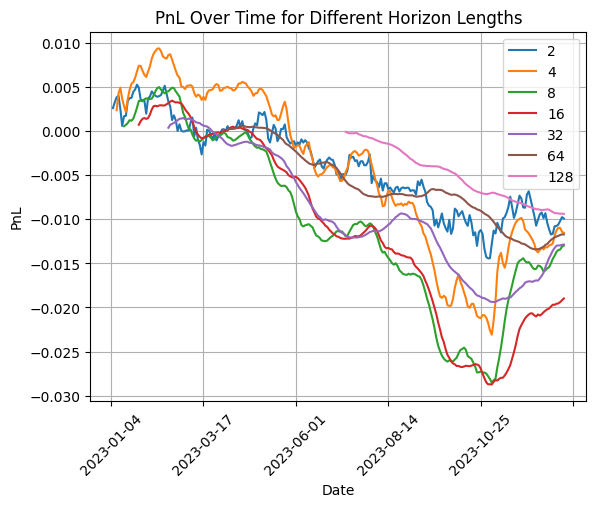

<Figure size 700x400 with 0 Axes>

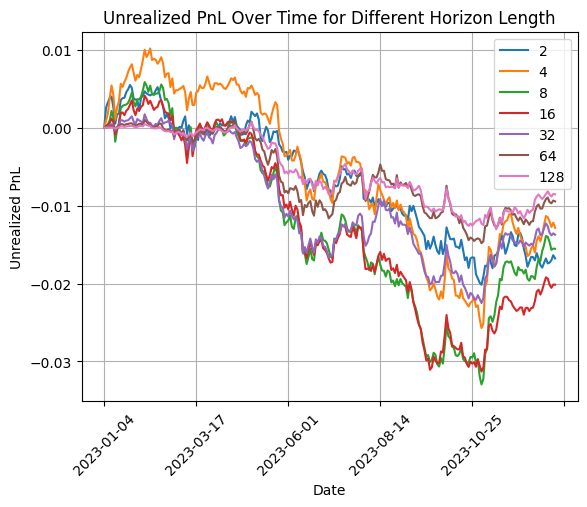

In [11]:
intervals = [2, 4, 8, 16, 32, 64, 128]
pnls = []
book_values = []
neutral_costs = []

for interval in intervals:
    pnl, neutral_cost, indiv_pnl, book_value = get_metrics(market=asset, interval=interval, model='original', \
             pos_dir=os.path.abspath(os.path.join(os.getcwd(), os.path.pardir, 'mock_trading')), df=df, market_neutral=True)
    pnls.append(pnl)
    book_values.append(book_value)
    neutral_costs.append(neutral_cost)
pnls = pd.DataFrame(pnls).T
pnls.columns = intervals
book_values = pd.DataFrame(book_values).T
book_values.columns = intervals

sharpes = pnls.apply(sharpe_ratio, axis=0) / np.sqrt(intervals)
mdds = pnls.apply(max_drawdown, axis=0)
ann_ret = pnls.apply(annual_returns, axis=0)
ann_vol = pnls.apply(annualized_volatility, axis=0) * np.sqrt(intervals)
metrics_df = pd.DataFrame({'Ann Sharpe': sharpes, 'Max Drawdown': mdds, 'Ann Returns': ann_ret, 'Ann Volatility': ann_vol, 'Neutral Cost(%)': neutral_costs})
metrics_df.index = intervals
metrics_df.index.name = 'Horizon'

# Plotting all PnLs on the same graph
plt.figure(figsize=(10, 10))
pnls.cumsum().plot()
plt.title('PnL Over Time for Different Horizon Lengths')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.grid(True)
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=0))
plt.xticks(rotation=45)
plt.show()

# Plotting all PnLs on the same graph
plt.figure(figsize=(7, 4))
book_values[book_values.index > '2023'].plot()
plt.title('Unrealized PnL Over Time for Different Horizon Length')
plt.xlabel('Date')
plt.ylabel('Unrealized PnL')
plt.legend()
plt.grid(True)
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=0.5))
plt.xticks(rotation=45)
plt.show()

In [12]:
metrics_df

,Ann Sharpe,Max Drawdown,Ann Returns,Ann Volatility,Neutral Cost(%)
Horizon,,,,,
2,-0.547725,-0.019568,-0.010205,0.018632,-0.002017
4,-0.579611,-0.032120,-0.011958,0.020632,-0.007031
8,-0.715216,-0.033306,-0.013689,0.019139,-0.018471
16,-1.075917,-0.032039,-0.020703,0.019242,-0.057859
32,-0.833136,-0.020804,-0.015089,0.018111,-0.081114
64,-1.084598,-0.013986,-0.016151,0.014891,-0.150185
128,-1.748321,-0.009283,-0.019886,0.011375,-0.242405
